# Эксперименты по анализу новостей Telegram для прогноза MOEX

Этот ноутбук содержит эксперименты и исследования системы анализа новостей.


In [2]:
# Импорты
import sys
from pathlib import Path

# Добавляем корневую директорию в путь
sys.path.insert(0, str(Path.cwd().parent))

import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pytz

from src.models import Post, PriceLabel, NewsFeature, Prediction
from src.ingest_telegram import TelegramPostsParser
from src.load_moex import MOEXClient
from src.baseline import TextProcessor
from src.llm_features import LLMFeatureExtractor
from src.classifier import DirectionClassifier
from src.evaluate import ModelEvaluator

print("Импорты успешно загружены")


Импорты успешно загружены


## 1. Загрузка конфигурации и инициализация компонентов


In [5]:
# Загрузка конфигурации
config_path = "../configs/config.yaml"
with open(config_path, "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)

print("Конфигурация загружена:")
print(f"  Тикеры: {config['task']['tickers']}")
print(f"  Окно новостей (W): {config['task']['window_hours']} часов")
print(f"  Горизонт прогноза (H): {config['task']['horizon_hours']} часов")


Конфигурация загружена:
  Тикеры: ['GAZP', 'SBER', 'LKOH']
  Окно новостей (W): 24 часов
  Горизонт прогноза (H): 24 часов


## 2. Исследование данных Telegram


In [11]:
# Загрузка постов из файла (если есть)
posts_file = "../data/telegram/posts.json"
posts = []
import json
with open(posts_file, "r", encoding="utf-8") as f:
    data = json.load(f)
    posts = [Post(**p) for p in data.get("posts", [])]
print(f"Загружено {len(posts)} постов из файла")

# Анализ постов
if posts:
    print(f"\nСтатистика постов:")
    print(f"  Всего постов: {len(posts)}")
    print(f"  Уникальных каналов: {len(set(p.id for p in posts))}")
    
    # Примеры постов
    print(f"\nПримеры постов (первые 3):")
    for i, post in enumerate(posts[:3]):
        print(f"\n  Пост {i+1}:")
        print(f"    Дата: {post.date}")
        print(f"    Текст: {post.text[:100]}...")
        print(f"    Просмотры: {post.views}, Пересылки: {post.forwards}")


Загружено 541 постов из файла

Статистика постов:
  Всего постов: 541
  Уникальных каналов: 541

Примеры постов (первые 3):

  Пост 1:
    Дата: 2023-12-29 14:13:40+00:00
    Текст: **🎄**** Вот и закончился этот торговый год. Надеемся, что для вас он был успешным! **

Мы подготовил...
    Просмотры: 25959, Пересылки: 87

  Пост 2:
    Дата: 2023-12-28 12:30:12+00:00
    Текст: **💫**** Встречаем на бирже нового эмитента**

Смотрите церемонию начала торгов [по ссылке](https://y...
    Просмотры: 21368, Пересылки: 17

  Пост 3:
    Дата: 2023-12-28 09:45:51+00:00
    Текст: **🔔**** Начало торгов акциями ПАО «МГКЛ»**

Это крупнейшая в Московском регионе и старейшая российск...
    Просмотры: 17057, Пересылки: 28


## 3. Анализ котировок MOEX


GAZP: загружено 100 записей
SBER: загружено 100 записей
LKOH: загружено 100 записей


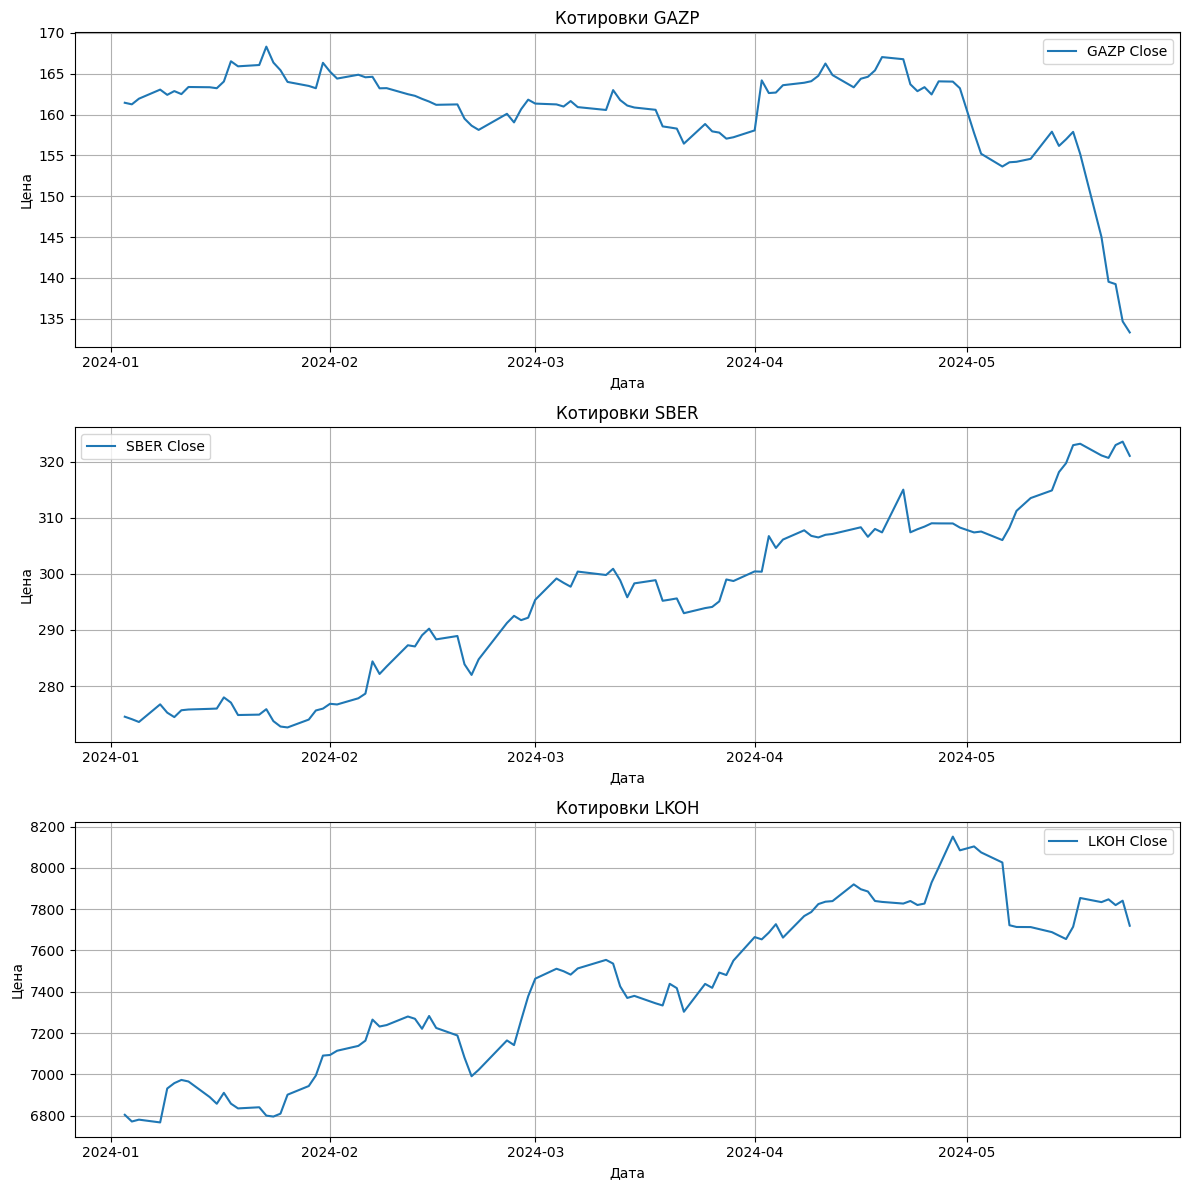

In [12]:
# Инициализация MOEX клиента
moex_client = MOEXClient()
msk_tz = pytz.timezone("Europe/Moscow")

# Загрузка котировок для анализа
tickers = config["task"]["tickers"]
start_date = datetime.strptime(config["task"]["start_date"], "%Y-%m-%d").replace(tzinfo=msk_tz)
end_date = datetime.strptime(config["task"]["end_date"], "%Y-%m-%d").replace(tzinfo=msk_tz)

ohlcv_data = {}
for ticker in tickers:
    try:
        df = moex_client.get_ohlcv(ticker, start_date, end_date)
        ohlcv_data[ticker] = df
        print(f"{ticker}: загружено {len(df)} записей")
    except Exception as e:
        print(f"Ошибка загрузки {ticker}: {e}")

# Визуализация котировок
if ohlcv_data:
    fig, axes = plt.subplots(len(ohlcv_data), 1, figsize=(12, 4 * len(ohlcv_data)))
    if len(ohlcv_data) == 1:
        axes = [axes]
    
    for idx, (ticker, df) in enumerate(ohlcv_data.items()):
        if not df.empty and "close" in df.columns:
            axes[idx].plot(df.index, df["close"], label=f"{ticker} Close")
            axes[idx].set_title(f"Котировки {ticker}")
            axes[idx].set_xlabel("Дата")
            axes[idx].set_ylabel("Цена")
            axes[idx].legend()
            axes[idx].grid(True)
    
    plt.tight_layout()
    plt.show()


## 4. Абляционные эксперименты: влияние параметров W и H


In [13]:
# Эксперименты с разными параметрами окна W и горизонта H
window_hours_options = [12, 24, 48]
horizon_hours_options = [24, 48]

results_ablation = []

print("Запуск абляционных экспериментов...")
print("Это может занять некоторое время...\n")

# Здесь можно запустить эксперименты с разными параметрами
# Для демонстрации создаем структуру результатов

for window_h in window_hours_options:
    for horizon_h in horizon_hours_options:
        print(f"  W={window_h}h, H={horizon_h}h - эксперимент можно запустить через run_experiment.py")
        results_ablation.append({
            "window_hours": window_h,
            "horizon_hours": horizon_h,
            "accuracy": None,  # Будет заполнено после запуска
        })

print(f"\nСоздано {len(results_ablation)} конфигураций для экспериментов")
print("\nДля запуска экспериментов используйте:")
print("  python run_experiment.py --window <W> --horizon <H>")


Запуск абляционных экспериментов...
Это может занять некоторое время...

  W=12h, H=24h - эксперимент можно запустить через run_experiment.py
  W=12h, H=48h - эксперимент можно запустить через run_experiment.py
  W=24h, H=24h - эксперимент можно запустить через run_experiment.py
  W=24h, H=48h - эксперимент можно запустить через run_experiment.py
  W=48h, H=24h - эксперимент можно запустить через run_experiment.py
  W=48h, H=48h - эксперимент можно запустить через run_experiment.py

Создано 6 конфигураций для экспериментов

Для запуска экспериментов используйте:
  python run_experiment.py --window <W> --horizon <H>


## 5. Сравнение методов классификации


In [14]:
# Сравнение разных методов классификации
methods = ["zero-shot", "few-shot", "logistic", "gradient_boosting"]

print("Доступные методы классификации:")
for method in methods:
    print(f"  - {method}")

print("\nДля сравнения методов измените параметр 'method' в config.yaml")
print("или используйте разные конфигурационные файлы.")


Доступные методы классификации:
  - zero-shot
  - few-shot
  - logistic
  - gradient_boosting

Для сравнения методов измените параметр 'method' в config.yaml
или используйте разные конфигурационные файлы.


## 6. Визуализация результатов оценки


In [ ]:
# Загрузка результатов оценки (если есть)
results_file = Path(config["output"]["results_path"])

if results_file.exists():
    import json
    with open(results_file, "r", encoding="utf-8") as f:
        results = json.load(f)
    
    print("Результаты оценки:")
    metrics = results.get("metrics", {})
    print(f"  Accuracy: {metrics.get('accuracy', 0):.4f}")
    print(f"  Precision: {metrics.get('precision', 0):.4f}")
    print(f"  Recall: {metrics.get('recall', 0):.4f}")
    print(f"  F1-Score: {metrics.get('f1_score', 0):.4f}")
    
    # Визуализация confusion matrix
    cm = np.array(results.get("confusion_matrix", [[0, 0], [0, 0]]))
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Down", "Up"], 
                yticklabels=["Down", "Up"])
    plt.title("Confusion Matrix")
    plt.ylabel("Истинное значение")
    plt.xlabel("Предсказанное значение")
    plt.show()
    
    # Визуализация метрик
    metric_names = ["accuracy", "precision", "recall", "f1_score"]
    metric_values = [metrics.get(m, 0) for m in metric_names]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(metric_names, metric_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    plt.ylim(0, 1)
    plt.ylabel("Значение метрики")
    plt.title("Метрики качества модели")
    plt.grid(axis='y', alpha=0.3)
    
    # Добавляем значения на столбцы
    for bar, value in zip(bars, metric_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
else:
    print("Файл с результатами не найден. Запустите эксперимент через run_experiment.py")


## 7. Анализ ошибок модели

Здесь можно провести детальный анализ ошибок классификации.


In [ ]:
# Пример анализа ошибок
# Можно загрузить предсказания и метки для детального анализа

print("Для анализа ошибок:")
print("1. Загрузите результаты эксперимента")
print("2. Сопоставьте предсказания и истинные метки")
print("3. Проанализируйте случаи неправильной классификации")
print("4. Изучите признаки новостей, которые привели к ошибкам")
